In [28]:
# Import the pandas_market_calendars module
%pip install pandas_market_calendars
import pandas_market_calendars as mcal

from datetime import datetime
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pandas.plotting import lag_plot

Note: you may need to restart the kernel to use updated packages.


In [3]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_ruble_data.csv")
data.head()

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
0,125.26,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
1,134.80,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
2,130.50,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
3,130.30,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425
4,130.20,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425


### Missing Values

In [39]:
data.isnull().sum()

currency_rate             0
date                      0
year                      0
quarter                   0
month                     0
day                       0
dow                       0
weekend                   0
currency_rate_change      1
denomination              0
RUB                       0
GDP_per_capita          169
Brent_price               0
GDP_deflator            169
FD_investment           169
Inflation               169
Brent_roll               11
Brent_lag1                1
dtype: int64

In [38]:
data[data.isnull().all(axis=1)]

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,Brent_roll,Brent_lag1


In [ ]:

data.where(data["GDP_per_capita"].isna())

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,Brent_roll,Brent_lag1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025.0,3.0,8.0,18.0,1.0,False,0.503859,post,80.4256,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7666,80.3466,2025-08-19,2025.0,3.0,8.0,19.0,2.0,False,-0.098227,post,80.3466,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7667,80.1045,2025-08-20,2025.0,3.0,8.0,20.0,3.0,False,-0.301320,post,80.1045,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7668,80.2548,2025-08-21,2025.0,3.0,8.0,21.0,4.0,False,0.187630,post,80.2548,NaN,67.83,NaN,NaN,NaN,67.83,67.83


In [12]:
shocks = {
    "1998 Default": "1998-08-17",
    "2008 GFC": "2008-09-15",
    "2014 Crimea": "2014-03-01",
    "2020 COVID": "2020-03-11",
    "2022 Invasion": "2022-02-24"
}

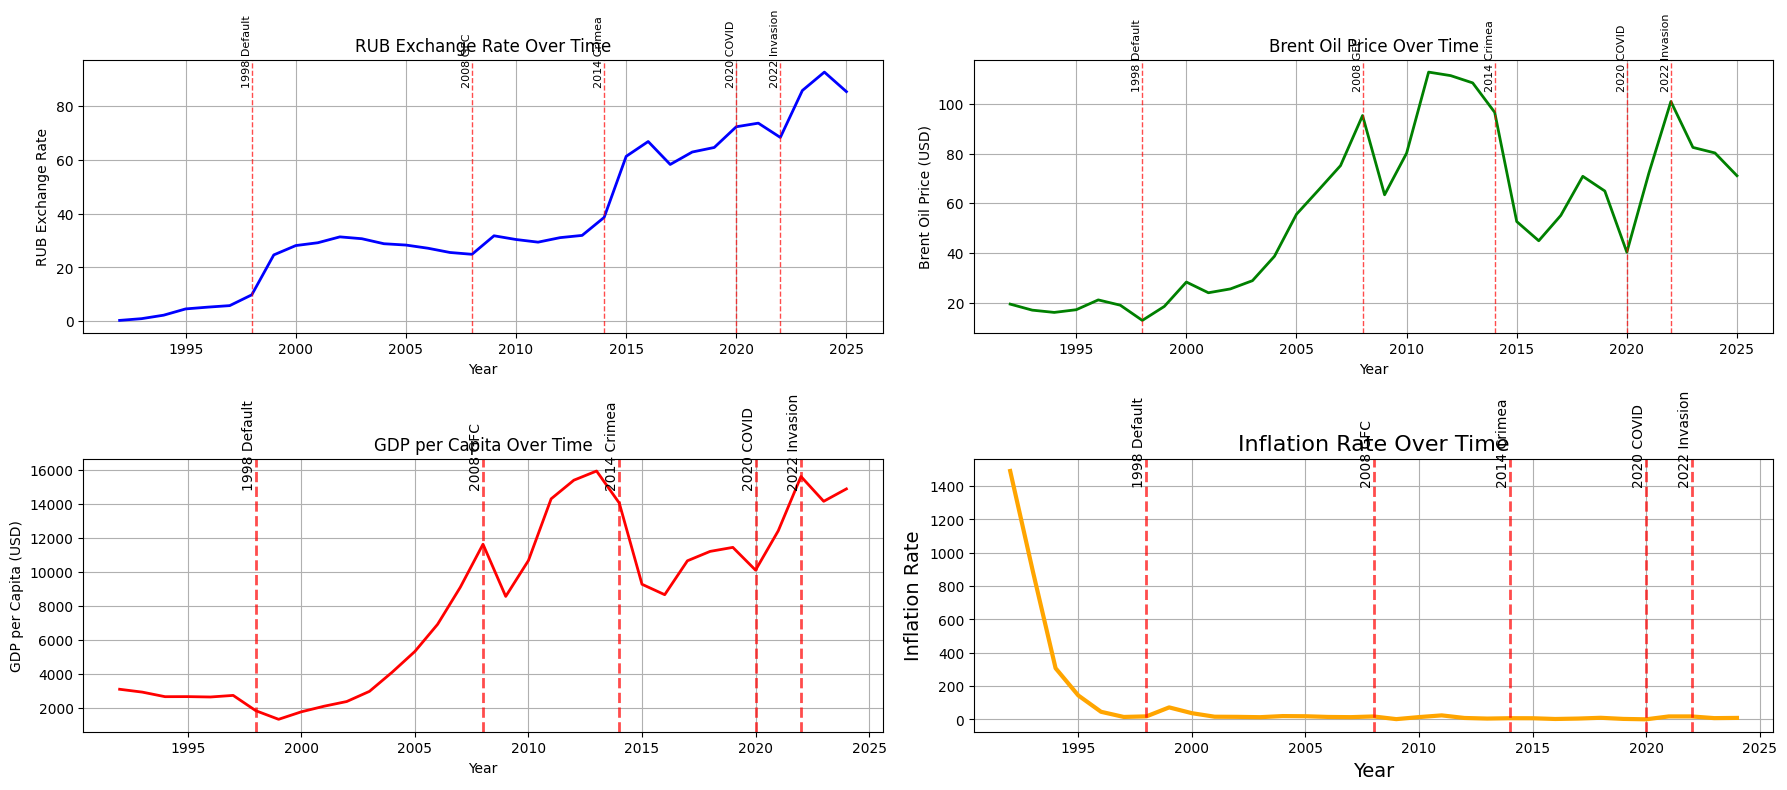

In [29]:
# 1. RUB over time
plt.figure(figsize=(18, 8))

plt.subplot(2, 2, 1)
data.groupby('year')['RUB'].mean().plot(title='RUB Exchange Rate Over Time', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('RUB Exchange Rate')
plt.grid(True)


for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=1)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=8, ha='right')

# 2. Brent price
plt.subplot(2, 2, 2)
data.groupby('year')['Brent_price'].mean().plot(title='Brent Oil Price Over Time', color='green', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Brent Oil Price (USD)')
plt.grid(True)


for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=1)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=8, ha='right')

# 3. GDP per capita
plt.subplot(2, 2, 3)
data.groupby('year')['GDP_per_capita'].mean().plot(title='GDP per Capita Over Time', color='red', linewidth=2)
plt.xlabel('Year')
plt.ylabel('GDP per Capita (USD)')
plt.grid(True)


for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=10, ha='right')

# 4. Inflation
plt.subplot(2, 2, 4)
data.groupby('year')['Inflation'].mean().plot(title='Inflation Rate Over Time', color='orange', linewidth=3)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Inflation Rate', fontsize=14)
plt.title('Inflation Rate Over Time', fontsize=16)
plt.grid(True)

#
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=10, ha='right')

plt.tight_layout()
plt.show()

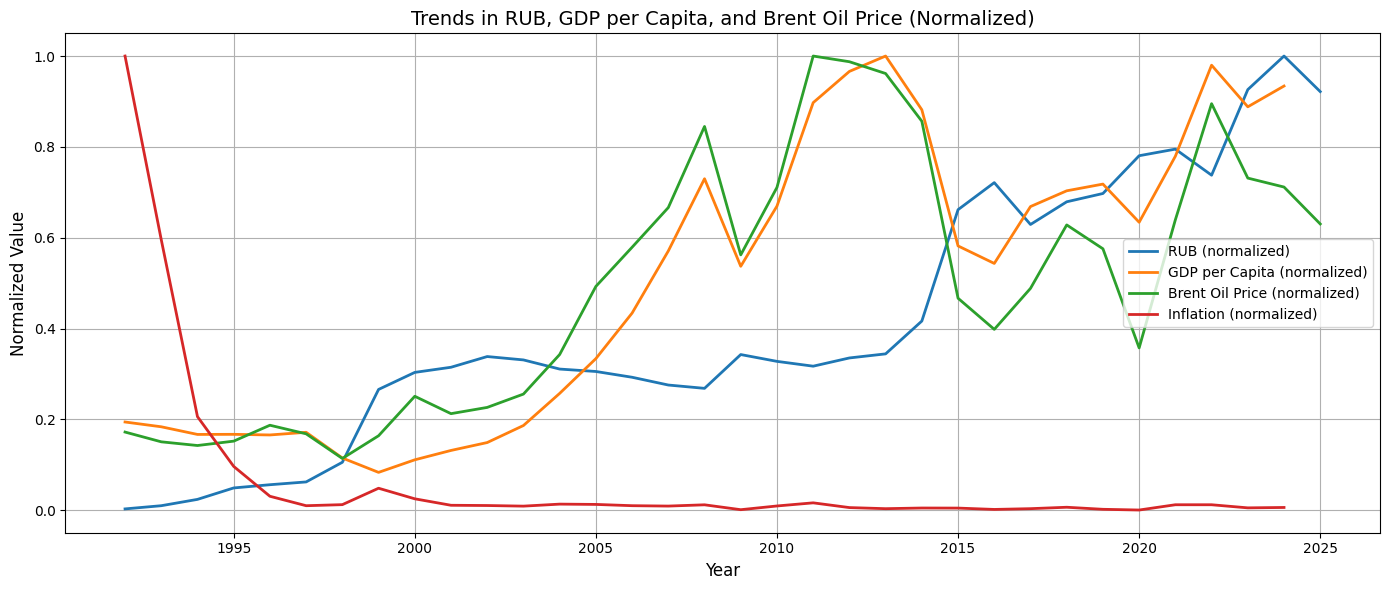

In [5]:
annual_data = data.groupby("year").agg({
    "RUB": "mean",
    "GDP_per_capita": "mean",
    "Brent_price": "mean", 
    "Inflation": "mean",
}).reset_index()


annual_data["RUB_norm"] = annual_data["RUB"] / annual_data["RUB"].max()
annual_data["GDP_norm"] = annual_data["GDP_per_capita"] / annual_data["GDP_per_capita"].max()
annual_data["Brent_norm"] = annual_data["Brent_price"] / annual_data["Brent_price"].max()
annual_data["Infl_norm"] = annual_data["Inflation"] / annual_data["Inflation"].max()


plt.figure(figsize=(14, 6))
plt.plot(annual_data["year"], annual_data["RUB_norm"], label="RUB (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["GDP_norm"], label="GDP per Capita (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["Brent_norm"], label="Brent Oil Price (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["Infl_norm"], label="Inflation (normalized)", linewidth=2)


plt.title("Trends in RUB, GDP per Capita, and Brent Oil Price (Normalized)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### Descriptive Statistics

In [30]:
data.describe()

,currency_rate,year,quarter,month,day,dow,currency_rate_change,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,Brent_roll,Brent_lag1
count,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000,7669.000000,7670.000000,7501.000000,7670.000000,7501.000000,7.501000e+03,7501.000000,7659.000000,7669.000000
mean,464.412233,2009.638592,2.549674,6.655541,16.126467,4.002868,0.082222,40.684786,8444.586039,58.639331,43.493591,2.012693e+10,43.493591,58.660214,58.638133
std,1388.749361,9.026007,1.105857,3.393557,8.750473,1.410055,1.888115,25.050811,4932.174236,31.977625,161.840493,2.511596e+10,161.840493,31.926004,31.979538
min,5.960000,1992.000000,1.000000,1.000000,1.000000,1.000000,-99.900000,0.125260,1330.757202,9.910000,0.898246,-3.980094e+10,0.898246,9.910000,9.910000
25%,28.670200,2002.000000,2.000000,4.000000,9.000000,3.000000,-0.202429,27.068600,2737.572021,27.560000,7.490071,2.847300e+09,7.490071,27.706667,27.560000
50%,32.795300,2010.000000,3.000000,7.000000,16.000000,4.000000,0.010268,30.838700,9101.239258,59.090000,15.058504,9.478810e+09,15.058504,59.035000,59.090000
75%,72.388225,2017.000000,4.000000,10.000000,24.000000,5.000000,0.261026,63.116000,12425.029297,80.370000,18.538967,3.759477e+10,18.538967,80.200000,80.370000
max,5960.000000,2025.000000,4.000000,12.000000,31.000000,7.000000,38.581010,120.378500,15941.448242,138.400000,1490.418425,7.478291e+10,1490.418425,138.400000,138.400000


### Distribution

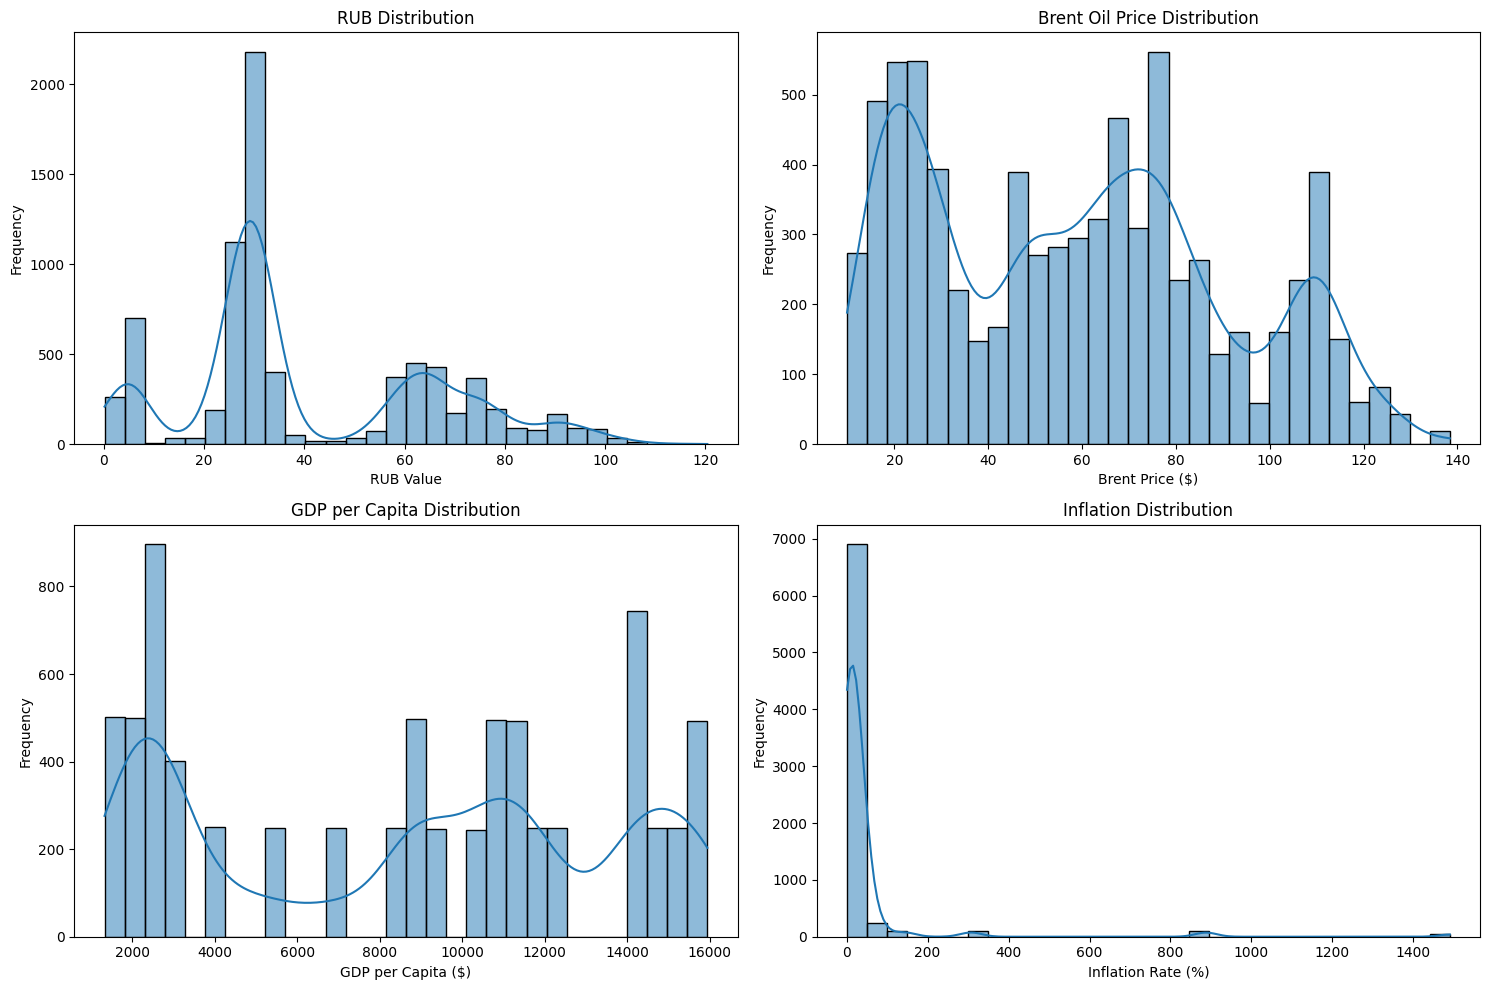

In [32]:
# Create subplots for 4 metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot RUB distribution
sns.histplot(data['RUB'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('RUB Distribution')
axes[0,0].set_xlabel('RUB Value')
axes[0,0].set_ylabel('Frequency')

# Plot Brent Oil Price distribution
sns.histplot(data['Brent_price'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Brent Oil Price Distribution')
axes[0,1].set_xlabel('Brent Price ($)')
axes[0,1].set_ylabel('Frequency')

# Plot GDP per Capita distribution
sns.histplot(data['GDP_per_capita'], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title('GDP per Capita Distribution')
axes[1,0].set_xlabel('GDP per Capita ($)')
axes[1,0].set_ylabel('Frequency')

# Plot Inflation distribution
sns.histplot(data['Inflation'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title('Inflation Distribution')
axes[1,1].set_xlabel('Inflation Rate (%)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<Axes: >

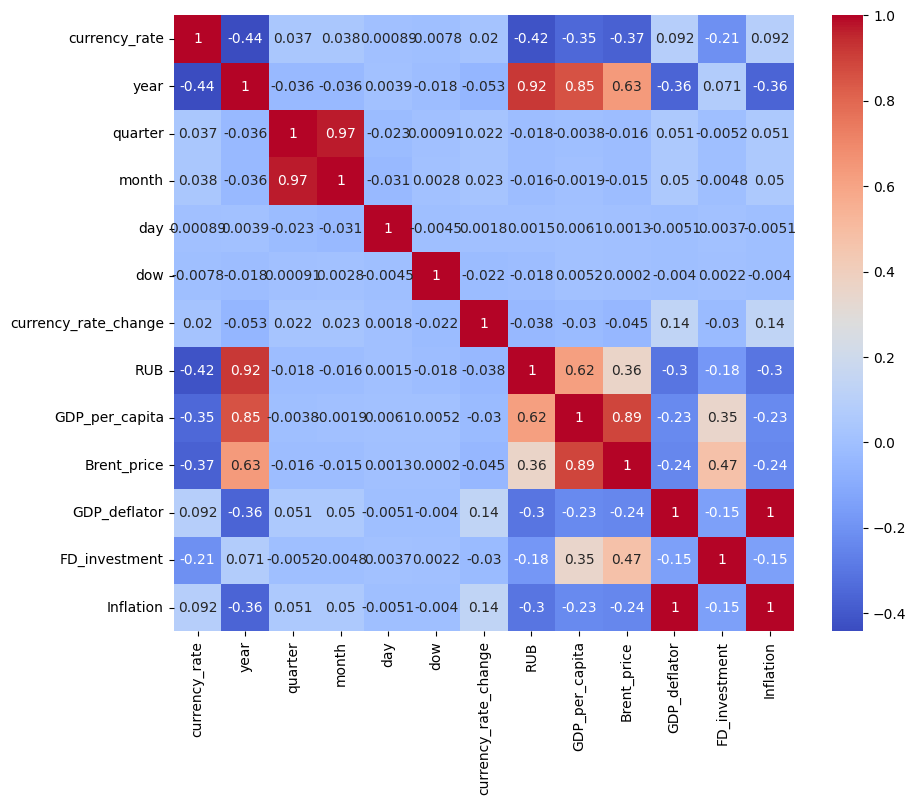

In [ ]:
num_data = data.select_dtypes(include='number')
corr = num_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

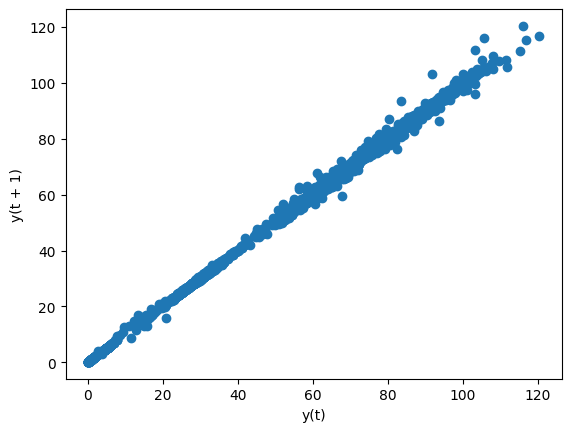

In [ ]:
# Rolling average of Brent
data['Brent_roll'] = data['Brent_price'].rolling(12).mean()
data['Brent_lag1'] = data['Brent_price'].shift(1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

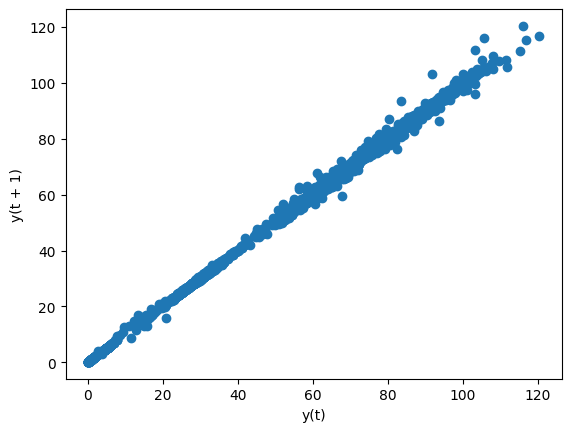

In [27]:
lag_plot(data['RUB'])

In [26]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,Brent_roll,Brent_lag1
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,NaN
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480,NaN,67.83,NaN,NaN,NaN,67.83,67.83
